# Requirements on methodology and results:
- define your own model based on CNN (do not use pre-defined architectures or pre-trained models)
 - solve the problem using at least 2 different approaches. By approaches, we mean architectures, optimizers, regularizations, preprocessing, etc., not just different values of the hyperparameters.
- report analysis of fundamental metrics, such as accuracy, f1, precision, and recall. Screenshoots of the output of some model is not sufficient. You must elaborate the results providing better visualizations and specific comments.
- conduct an analysis of at least one hyperparameter in relation to the chosen metrics.

In practice, you have to define two different approaches, train them with different hyperparameters, compare them (performance vs hyperparameter), visualize the results in proper forms (figures, tables), and discuss the results.
Any software library can be used, including Python (tensorflow or pytorch), MATLAB, etc.

The output of the assignment should be:
1) A PDF report (no other format is accepted) of about 10 pages, with your name and matricola code) describing the implemented solution: data pre-processing (if any), the exact model (with all the layers) that has been designed, the chosen optimizer, hyperparameter search, description of the evaluation method, comparative results using appropriate metrics, including training time, and discussion about the results. Conclusions should discuss the comparative results.
2) A ZIP file with the code you used in the project (not including the dataset)
3) [optional] a video (or a link to a video) showing the execution of the learned function as the policy driving the racing car on some tracks in the Gym environment (see the snippet of code in the dataset folder).

# Setting up dataset

In [ ]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:", gpus)
else:
    print("No GPUs detected")


No GPUs detected


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Paths to dataset
train_dir = 'C:/Users/Giovanni/OneDrive/Desktop/dataset/train'
test_dir = 'C:/Users/Giovanni/OneDrive/Desktop/dataset/test'


# Image size and batch size
img_size = (96, 96)
batch_size = 32

# Define normalization layer
normalization_layer = layers.Rescaling(1./255)  # Scale pixel values to [0, 1]

# Load train and test datasets
train_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset = 'training',
    seed = 1,
    label_mode='categorical'  # For multi-class classification
)

val_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset = 'validation',
    seed = 1,
    label_mode='categorical'  # For multi-class classification
)

test_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Save class names before applying `.map()`
class_names_train = train_data_raw.class_names
class_names_val = val_data_raw.class_names
class_names_test = test_data_raw.class_names

# Apply normalization
normalization_layer = layers.Rescaling(1./255)
train_data = train_data_raw.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data_raw.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data_raw.map(lambda x, y: (normalization_layer(x), y))


# Prefetch for performance
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)



Found 6369 files belonging to 5 classes.
Using 5096 files for training.
Found 6369 files belonging to 5 classes.
Using 1273 files for validation.
Found 2749 files belonging to 5 classes.


I've created a `tf.data.Dataset` object directly from a directory of images, making it convenient to prepare image datasets for the model.

---
### Key Parameters
1. **`directory structure example`**:

     ```
     train/
         0/
             image1.jpg
             image2.jpg
         1/
             image3.jpg
             image4.jpg
          .
          .
          .
     ```
   - Each subdirectory (e.g., `class_a`, `class_b`) is considered a class, and the images inside are automatically labeled with the corresponding class.

2. **`label_mode`**:
  - `'int'`: Labels are integers representing the class indices.
  - `'categorical'`: Labels are one-hot encoded arrays (useful for multi-class classification).
  - `'binary'`: Labels are 0 or 1 (for binary classification).
  - `None`: No labels are returned, and the dataset only contains images.

I chose categorical so that labels are automatically inferred based on the directory names and I have one-hot encoding.

---

# catyegorical crossentropy models:


# CNN 1

In [ ]:
#F1_SCORE2
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    """
    Compute the macro-averaged F1 score for multi-class classification.

    Arguments:
    y_true -- Ground truth labels (one-hot encoded).
    y_pred -- Predicted labels (probabilities).

    Returns:
    Macro-averaged F1 score.
    """
    # Convert predictions to binary matrix (one-hot encoded)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=tf.shape(y_pred)[-1])

    # Calculate True Positives, False Positives, and False Negatives
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    # Calculate Precision and Recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Macro-average F1 score (average over all classes)
    macro_f1 = K.mean(f1)

    return macro_f1



In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model_1(learning_rate, stride, epochs):
    model = models.Sequential([
    layers.InputLayer(shape=(96, 96, 3)),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 classes
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_score])  # F1 score
    return model

# Define the grid of hyperparameters
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'stride': [(2, 2)],
    'epochs' : [10, 20]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Set model checkpoint to save the best model based on validation loss

model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model1.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1)



In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model(learning_rate, stride, num_layers, epochs):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(96, 96, 3)))

    # Add convolutional + pooling layers dynamically
    for i in range(num_layers):
        model.add(layers.Conv2D(16 * (2 ** i), (3, 3), strides=stride, activation='relu',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))  # 5 classes

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_score])  # F1 score
    return model

# Define the grid of hyperparameters
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'stride': [(2, 2)],
    'num_layers': [2, 3],
    'epochs' : [15, 30]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



## train build_model_1 - CNN 1a

In [ ]:

# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_params = {}

# List to log results
results_log = []
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model1.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model_1(params['learning_rate'], params['stride'], params['epochs'])
    history_1 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],  # Use the number of epochs from the grid
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history_1.history['val_accuracy'])
    val_f1_score = max(history_1.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history_1.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")


# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)


Testing with params: {'epochs': 15, 'learning_rate': 0.001, 'num_layers': 2, 'stride': (2, 2)}
Epoch 1/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4723 - f1_score: 0.3048 - loss: 1.3337
Epoch 1: val_loss improved from inf to 1.13319, saving model to /content/drive/MyDrive/best_model1.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.4732 - f1_score: 0.3058 - loss: 1.3324 - val_accuracy: 0.5797 - val_f1_score: 0.4190 - val_loss: 1.1332
Epoch 2/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5937 - f1_score: 0.4372 - loss: 1.0860
Epoch 2: val_loss improved from 1.13319 to 1.06679, saving model to /content/drive/MyDrive/best_model1.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.5938 - f1_score: 0.4374 - loss: 1.0859 - val_accuracy: 0.6127 - val_f1_score: 0.4518 - val_loss: 1.0668
Epoch 3/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6271 - f1_score: 0.4741 - loss: 1.0238
Epoch 3: val_loss improved from 1.06679 to 1.04874,

In [ ]:
# evaluate the best model on the test data
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5701 - f1_score: 0.3745 - loss: 1.2529
Test Loss: 1.2657575607299805
Test Accuracy: 0.5748
Test F1 Score: 0.3731


In [ ]:
# Save the best model explicitly after the grid search finishes
best_model_path = "/content/drive/MyDrive/firstCNN.keras"

if best_model is not None:
    best_model.save(best_model_path)
    print(f"Best model saved to: {best_model_path}")
else:
    print("No model to save. Grid search did not yield a best model.")

Best model saved to: /content/drive/MyDrive/firstCNN.keras


## train build_model - CNN 1b

In [ ]:

# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_params = {}

# List to log results
results_log = []
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model1.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")
    # Build and train the model
    model = build_model(params['learning_rate'], params['stride'], params['num_layers'], params['epochs'])
    history_1 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],  # Use the number of epochs from the grid
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history_1.history['val_accuracy'])
    val_f1_score = max(history_1.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history_1.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")


# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)


Testing with params: {'epochs': 15, 'learning_rate': 0.001, 'num_layers': 2, 'stride': (2, 2)}
Epoch 1/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3672 - f1_score: 0.2384 - loss: 2.0625
Epoch 1: val_loss improved from inf to 1.88037, saving model to /content/drive/MyDrive/best_model1.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3681 - f1_score: 0.2389 - loss: 2.0599 - val_accuracy: 0.3205 - val_f1_score: 0.0956 - val_loss: 1.8804
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5177 - f1_score: 0.3399 - loss: 1.5305
Epoch 2: val_loss improved from 1.88037 to 1.74621, saving model to /content/drive/MyDrive/best_model1.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5178 - f1_score: 0.3399 - loss: 1.5303 - val_accuracy: 0.4375 - val_f1_score: 0.2645 - val_loss: 1.7462
Epoch 3/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5457 - f1_score: 0.3586 - loss: 1.3914
Epoch 3: val_loss improved from 1.74621 to 1.64340, s

In [ ]:
# Save the best model explicitly after the grid search finishes
best_model_path = "/content/drive/MyDrive/firstCNN_second_train.keras"

if best_model is not None:
    best_model.save(best_model_path)
    print(f"Best model saved to: {best_model_path}")
else:
    print("No model to save. Grid search did not yield a best model.")

Best model saved to: /content/drive/MyDrive/firstCNN_second_train.keras


In [ ]:
# evaluate the best model on the test data
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4482 - f1_score: 0.3161 - loss: 1.8367
Test Loss: 1.873548150062561
Test Accuracy: 0.4394
Test F1 Score: 0.3076


## pred

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# Load and preprocess a single image
img_path = '/content/drive/MyDrive/ML/MLHW2_image_classification/dataset/test/2/0001.png'
img = load_img(img_path, target_size=(96, 96))
img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
predictions = model.predict(img_array)
predicted_label = np.argmax(predictions)
label_map = {0: "do nothing", 1: "steer left", 2: "steer right", 3: "gas", 4: "brake"}
print("Predicted label:", label_map[predicted_label])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted label: gas


# CNN 2 - tried f1_score1, these (very high) metrics are invalid for the analysis purpose

Dataset is organized into folders for 5 classes (0, 1, 2, 3, and 4), where the labels are one-hot encoded due to label_mode='categorical'.

y_true represents the true labels in a one-hot encoded format.
y_pred represents the predicted probabilities from the model.
Multi-class Classification:
The function computes the F1 score for each class and averages them to produce the macro-averaged F1 score. This is ideal when:

You are dealing with imbalanced classes (which you mentioned earlier).
Macro-average ensures each class contributes equally to the final F1 score, regardless of class imbalance.
TensorFlow Compatibility:
The function avoids Python loops and uses TensorFlow/Keras operations (e.g., tf.argmax, K.sum, K.epsilon()) to ensure symbolic tensors are handled correctly. This makes it compatible with TensorFlow's graph execution and ensures the metric works with model.compile().



Both `f1_score1` and `f1_score2` are valid implementations of the F1 score for multi-class classification, but they differ in how the F1 score is calculated and averaged. The choice of which one to use depends on the problem and how to interpret the metric.

---

### **Differences Between `f1_score1` and `f1_score2`**

#### 1. **`f1_score1`: Global F1 Score**
   - **How It Works**:
     - `f1_score1` calculates precision, recall, and the F1 score globally (across all samples in the dataset) without explicitly considering each class individually.
     - It computes the true positives (TP), false positives (FP), and false negatives (FN) over all predictions, treating the problem as if it were binary for all samples.
   - **Outcome**:
     - This method gives a single F1 score that represents the overall performance of the model across all classes.
     - It can sometimes overestimate the F1 score, especially if there’s a class imbalance, because it doesn’t handle the contribution of each class independently.

---

#### 2. **`f1_score2`: Macro-Averaged F1 Score**
   - **How It Works**:
     - `f1_score2` calculates the F1 score for each class independently.
     - It computes precision, recall, and F1 for each class, then averages these scores to produce a **macro-average F1 score**.
   - **Outcome**:
     - This method ensures that each class contributes equally to the final F1 score, regardless of how many samples belong to that class.
     - If you have imbalanced classes, this approach provides a fairer representation of performance across all classes.
     - The resulting score might appear lower than `f1_score1` because it penalizes poor performance in minority classes more strongly.

---

### **Why `f1_score1` Produces Better Results**
1. **Global Calculation Bias**:
   - `f1_score1` treats all classes together, so if you have a large number of samples in certain classes, the performance of these classes will dominate the overall score.
   - For example, if the model performs well on majority classes but poorly on minority classes, `f1_score1` might still report a high F1 score because it ignores class-level contributions.

2. **Class Imbalance**:
   - If the dataset is imbalanced, `f1_score1` will likely overestimate the model's performance by prioritizing the dominant classes.
   - `f1_score2`, on the other hand, ensures that minority classes are accounted for in the final score, which might lead to a lower but more realistic F1 score.

3. **Metric Misinterpretation**:
   - If the dataset is balanced, the differences between the two methods will be minimal. However, for imbalanced datasets, the F1 score from `f1_score1` may give a false sense of good performance because it ignores the minority classes.

---

### **When to Use Which F1 Score**
- **Use `f1_score1`** if:
  - You care about the **overall performance** across all samples, regardless of individual class contributions.
  - The dataset is balanced, or you don’t need to evaluate class-specific performance.

- **Use `f1_score2`** if:
  - The dataset is imbalanced, and you want to ensure that **all classes contribute equally** to the final score.
  - You want a fair evaluation of how well the model performs across all classes.

---

### **Which One is "Better"?**
For multi-class classification tasks, **`f1_score2` (macro-averaged F1 score)** is generally considered more robust and appropriate, especially when you have imbalanced classes. It provides a better overall picture of the model's performance across all classes.

If `f1_score1` gives you much better results, it may be masking poor performance on minority classes. This could lead to overconfidence in the model's ability to generalize. Switching to `f1_score2` would be better for a more realistic evaluation.

---

### **Key Takeaway**
`f1_score1` is not "wrong," but it is not ideal for multi-class classification when class imbalance exists. I should use `f1_score2` (macro-F1) for fairness across classes.

In [6]:
#F1_SCORE2
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    """
    Compute the macro-averaged F1 score for multi-class classification.

    Arguments:
    y_true -- Ground truth labels (one-hot encoded).
    y_pred -- Predicted labels (probabilities).

    Returns:
    Macro-averaged F1 score.
    """
    # Convert predictions to binary matrix (one-hot encoded)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=tf.shape(y_pred)[-1])

    # Calculate True Positives, False Positives, and False Negatives
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    # Calculate Precision and Recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Macro-average F1 score (average over all classes)
    macro_f1 = K.mean(f1)

    return macro_f1



In [ ]:
#F1_SCORE1
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    """
    Computes the F1 score for multi-class classification in TensorFlow.
    Args:
        y_true: Ground truth one-hot encoded labels
        y_pred: Predicted probabilities (output of softmax)
    Returns:
        F1 score
    """
    # Convert y_true and y_pred to one-hot tensors
    y_pred_classes = K.argmax(y_pred, axis=-1)  # Predicted class indices
    y_true_classes = K.argmax(y_true, axis=-1)  # True class indices

    # Cast to float32 to ensure compatibility
    y_pred_classes = K.cast(y_pred_classes, tf.float32)
    y_true_classes = K.cast(y_true_classes, tf.float32)

    # Compute true positives, false positives, and false negatives
    tp = K.sum(K.cast(K.equal(y_true_classes, y_pred_classes), tf.float32))
    fp = K.sum(K.cast(K.not_equal(y_true_classes, y_pred_classes) & K.equal(y_pred_classes, 1), tf.float32))
    fn = K.sum(K.cast(K.not_equal(y_true_classes, y_pred_classes) & K.equal(y_true_classes, 1), tf.float32))

    # Precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

## model

In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model(learning_rate, stride, num_layers, epochs):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(96, 96, 3)))

    # Add convolutional + pooling layers dynamically
    for i in range(num_layers):
        model.add(layers.Conv2D(16 * (2 ** i), (3, 3), strides=stride, activation='relu',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))  # 5 classes

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_score])  # F1 score
    return model

# Define the grid of hyperparameters
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'stride': [(2, 2)],
    'num_layers': [2, 3],
    'epochs' : [15, 30]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Set model checkpoint to save the best model based on validation loss
#model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_modelCNN2.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1)


## train with f1_score1

In [ ]:

# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_params = {}

# List to log results
results_log = []

# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model(params['learning_rate'], params['stride'], params['num_layers'], params['epochs'])
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],  # Use the number of epochs from the grid
        callbacks=[early_stopping],
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history.history['val_accuracy'])
    val_f1_score = max(history.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")


# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)


Testing with params: {'epochs': 15, 'learning_rate': 0.001, 'num_layers': 2, 'stride': (2, 2)}
Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3645 - f1_score: 0.4043 - loss: 2.0832
Epoch 1: val_loss improved from inf to 1.91128, saving model to best_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 1053s 5s/step - accuracy: 0.3650 - f1_score: 0.4049 - loss: 2.0820 - val_accuracy: 0.3266 - val_f1_score: 0.3571 - val_loss: 1.9113
Epoch 2/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5204 - f1_score: 0.5689 - loss: 1.5630
Epoch 2: val_loss improved from 1.91128 to 1.74230, saving model to best_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.5203 - f1_score: 0.5688 - loss: 1.5626 - val_accuracy: 0.4445 - val_f1_score: 0.4828 - val_loss: 1.7423
Epoch 3/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5294 - f1_score: 0.5755 - loss: 1.4380
Epoch 3: val_loss improved from 1.74230 to 1.56639, saving model to best_model.keras
160/160 ━━━━━━━

In [ ]:
print('best model summary:\n')
best_model.summary()

best model summary:



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 47, 47, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 47, 47, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 23, 23, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 11, 11, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 2, 2, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 2, 2, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,545 (384.95 KB)

 Trainable params: 32,773 (128.02 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 65,548 (256.05 KB)

In [ ]:
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")

Best Parameters (based on F1 Score): {'epochs': 30, 'learning_rate': 0.001, 'num_layers': 3, 'stride': (2, 2)}
Best Validation F1 Score: 0.8234947323799133


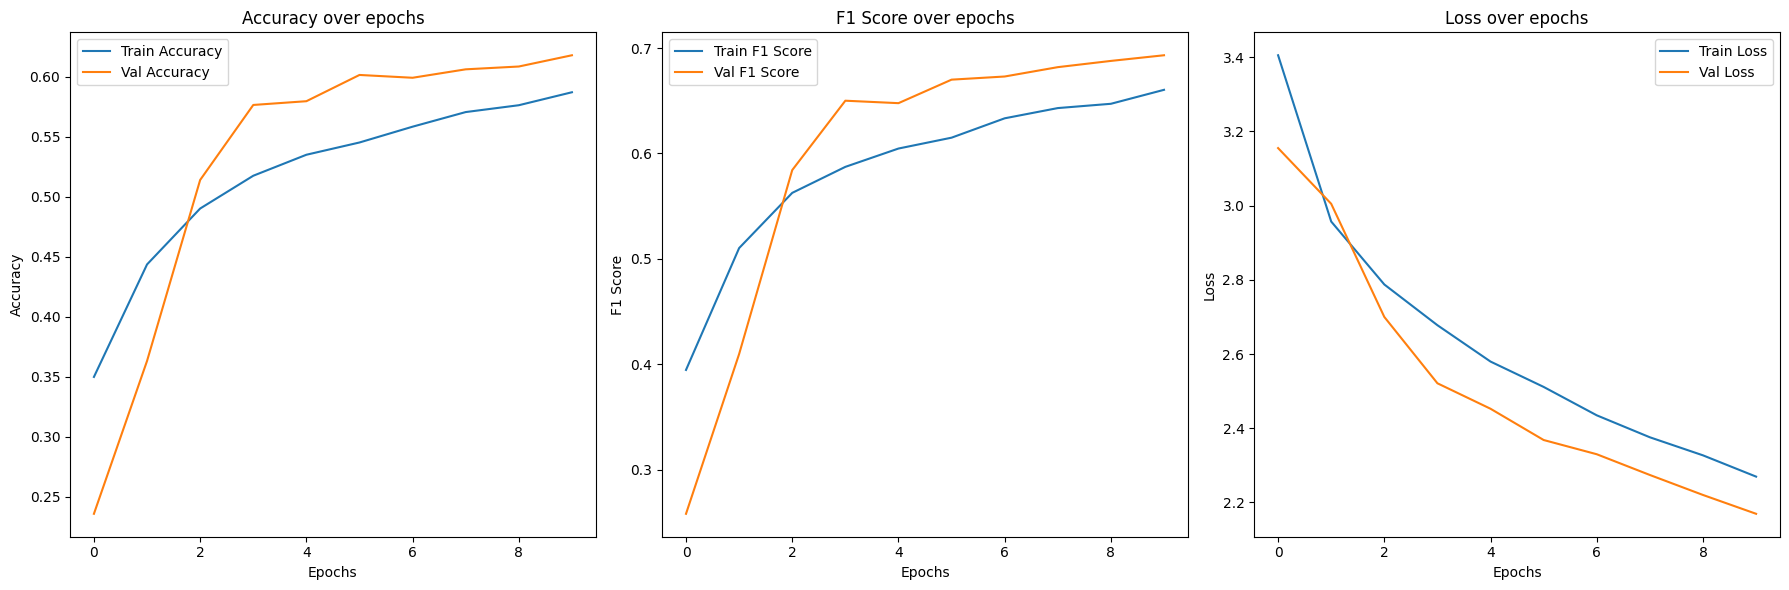


Grid Search Results:
                                               params  val_accuracy  \
0   {'epochs': 15, 'learning_rate': 0.001, 'num_la...      0.456250   
1   {'epochs': 15, 'learning_rate': 0.001, 'num_la...      0.631250   
2   {'epochs': 15, 'learning_rate': 0.0005, 'num_l...      0.551562   
3   {'epochs': 15, 'learning_rate': 0.0005, 'num_l...      0.668750   
4   {'epochs': 15, 'learning_rate': 0.0001, 'num_l...      0.549219   
5   {'epochs': 15, 'learning_rate': 0.0001, 'num_l...      0.604688   
6   {'epochs': 30, 'learning_rate': 0.001, 'num_la...      0.494531   
7   {'epochs': 30, 'learning_rate': 0.001, 'num_la...      0.688281   
8   {'epochs': 30, 'learning_rate': 0.0005, 'num_l...      0.546875   
9   {'epochs': 30, 'learning_rate': 0.0005, 'num_l...      0.658594   
10  {'epochs': 30, 'learning_rate': 0.0001, 'num_l...      0.551562   
11  {'epochs': 30, 'learning_rate': 0.0001, 'num_l...      0.617969   

    val_f1_score  val_loss  
0       0.504956  1.49367

In [ ]:

# plot the training history (Accuracy, F1 score, and Loss)
plt.figure(figsize=(18, 6))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot F1 score
plt.subplot(1, 3, 2)
plt.plot(history.history['f1_score'], label='Train F1 Score')
plt.plot(history.history['val_f1_score'], label='Val F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Plot loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display the grid search results
print("\nGrid Search Results:")
print(results_df)

# Optionally save the results to a CSV
#results_df.to_csv("grid_search_results.csv", index=False)


## eval

In [ ]:
# evaluate the best model on the test data
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.6710 - f1_score: 0.6964 - loss: 1.2538
Test Loss: 1.2288068532943726
Test Accuracy: 0.6795
Test F1 Score: 0.7042


# CNN 3

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model(learning_rate, stride, num_layers, num_dense_layers, dense_units):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(96, 96, 3)))

    # Add convolutional + pooling layers dynamically
    for i in range(num_layers):
        model.add(layers.Conv2D(16 * (2 ** i), (3, 3), strides=stride, activation='relu',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layers
    for _ in range(num_dense_layers):
        model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    #model.add(layers.Dropout(dropout_rate))  # Dropout for regularization
    model.add(layers.Dense(5, activation='softmax'))  # 5 classes

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_score])  # F1 score
    return model

# Define the grid of hyperparameters
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'stride': [(1, 1), (2, 2)],
    'num_layers': [2, 3],
    'num_dense_layers': [3, 4],  # Number of dense layers to explore
    'dense_units': [64, 128],   # Number of units in each dense layer  # Dropout rate for dense layers
    'epochs': [30, 50]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model_dense_layers.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1)



## train with dropout

In [ ]:
# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_params = {}

# List to log results
results_log = []

# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model(params['learning_rate'], params['stride'], params['num_layers'],
                        params['num_dense_layers'], params['dense_units'], params['dropout_rate'])
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],  # Use the number of epochs from the grid
        callbacks=[early_stopping],
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history.history['val_accuracy'])
    val_f1_score = max(history.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")

# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)

# Save results to a CSV file for future analysis
results_df.to_csv("grid_search_dense_results.csv", index=False)


Testing with params: {'dense_units': 64, 'dropout_rate': 0.3, 'epochs': 30, 'learning_rate': 0.001, 'num_dense_layers': 3, 'num_layers': 2, 'stride': (2, 2)}
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.3581 - f1_score: 0.1984 - loss: 2.8405 - val_accuracy: 0.3205 - val_f1_score: 0.0958 - val_loss: 1.9864
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5296 - f1_score: 0.3478 - loss: 1.6181 - val_accuracy: 0.2247 - val_f1_score: 0.0747 - val_loss: 1.7747
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5472 - f1_score: 0.3596 - loss: 1.4423 - val_accuracy: 0.5169 - val_f1_score: 0.3457 - val_loss: 1.5750
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5591 - f1_score: 0.3697 - loss: 1.3639 - val_accuracy: 0.3221 - val_f1_score: 0.1898 - val_loss: 1.6576
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5585 - f1_score: 0.3678 - loss: 1.3471 - val_accuracy: 0.3559 - val_f1_score: 0.2013 - va

## train 2 no dropout

In [ ]:
# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_accuracy = 0
best_params = {}

# List to log results
results_log = []

# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model(params['learning_rate'], params['stride'], params['num_layers'],
                        params['num_dense_layers'], params['dense_units'])
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],  # Use the number of epochs from the grid
        callbacks=[early_stopping],
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history.history['val_accuracy'])
    val_f1_score = max(history.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params
        best_accuracy = val_accuracy

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")

# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)

# Save results to a CSV file for future analysis
results_df.to_csv("grid_search_dense_results.csv", index=False)


Testing with params: {'dense_units': 64, 'epochs': 30, 'learning_rate': 0.001, 'num_dense_layers': 3, 'num_layers': 2, 'stride': (1, 1)}
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.3619 - f1_score: 0.1848 - loss: 2.8023 - val_accuracy: 0.3205 - val_f1_score: 0.0961 - val_loss: 1.9578
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5118 - f1_score: 0.3304 - loss: 1.6242 - val_accuracy: 0.3205 - val_f1_score: 0.0957 - val_loss: 1.7700
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5454 - f1_score: 0.3608 - loss: 1.4205 - val_accuracy: 0.2310 - val_f1_score: 0.0864 - val_loss: 1.7128
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5480 - f1_score: 0.3597 - loss: 1.3708 - val_accuracy: 0.5114 - val_f1_score: 0.3374 - val_loss: 1.4408
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.5587 - f1_score: 0.3708 - loss: 1.3379 - val_accuracy: 0.2239 - val_f1_score: 0.0718 - val_loss: 4.3904
Epoch 6

In [ ]:
# Save the best model explicitly after the grid search finishes
best_model_path = "best_gridsearch_model_2_no dropout.keras"

if best_model is not None:
    best_model.save(best_model_path)
    print(f"Best model saved to: {best_model_path}")
else:
    print("No model to save. Grid search did not yield a best model.")

Best model saved to: best_gridsearch_model_2_no dropout.keras


In [ ]:
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")

Best Parameters (based on F1 Score): {'dense_units': 128, 'dropout_rate': 0.5, 'epochs': 50, 'learning_rate': 0.0001, 'num_dense_layers': 3, 'num_layers': 3, 'stride': (2, 2)}
Best Validation F1 Score: 0.5013777017593384


## test

In [ ]:
# evaluate the best model on the test data      YES DROPOUT
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4513 - f1_score: 0.2988 - loss: 2.5711
Test Loss: 2.587204933166504
Test Accuracy: 0.4576
Test F1 Score: 0.3058


In [ ]:
# evaluate the best model on the test data      NO DROPOUT
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4243 - f1_score: 0.2994 - loss: 2.9468
Test Loss: 2.899754762649536
Test Accuracy: 0.4354
Test F1 Score: 0.3074


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

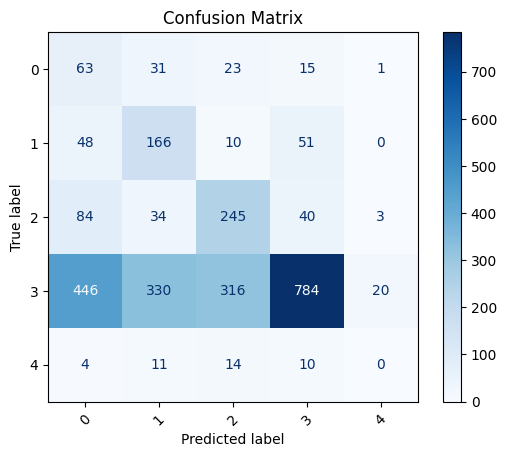

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get predictions and true labels
y_pred = []
y_true = []

# Iterate through test data to get predictions and true labels
for images, labels in test_data:
    # Predict using the best model
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Get true class indices

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_test)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# Final model - CNN 4

In [ ]:
#F1_SCORE2
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    """
    Compute the macro-averaged F1 score for multi-class classification.

    Arguments:
    y_true -- Ground truth labels (one-hot encoded).
    y_pred -- Predicted labels (probabilities).

    Returns:
    Macro-averaged F1 score.
    """
    # Convert predictions to binary matrix (one-hot encoded)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=tf.shape(y_pred)[-1])

    # Calculate True Positives, False Positives, and False Negatives
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    # Calculate Precision and Recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Macro-average F1 score (average over all classes)
    macro_f1 = K.mean(f1)

    return macro_f1



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model(learning_rate, stride, num_layers, num_dense_layers, dense_units, glob_avg_pooling, max_pooling):
    num_layers = int(num_layers)
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(96, 96, 3)))

    # Add convolutional + pooling layers dynamically
    for i in range(num_layers):
        model.add(layers.Conv2D(16 * (2 ** i), (3, 3), strides=stride, activation='relu',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())

        if max_pooling:
            model.add(layers.MaxPooling2D((2, 2)))
        else:
            model.add(layers.AveragePooling2D(2, 2))

    # Global Average Pooling
    if glob_avg_pooling:
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())

    # Fully connected layers
    for _ in range(num_dense_layers):
        model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    #model.add(layers.Dropout(dropout_rate))  # Dropout for regularization
    model.add(layers.Dense(5, activation='softmax'))  # 5 classes

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score])
    return model

# Define the grid of hyperparameters
param_grid = {
    'stride': [(1, 1), (2, 2)],
    'num_layers': [2, 3],
    'learning_rate': [0.0005, 0.001, 0.05],
    'num_dense_layers': [3, 4],  # Number of dense layers to explore
    'dense_units': [64, 128],   # Number of units in each dense layer  # Dropout rate for dense layers
    'epochs': [30, 50],
    'glob_avg_pooling': [True, False],
    'max_pooling': [True, False]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)




## train

In [ ]:
# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_accuracy = 0
best_params = {}

# List to log results
results_log = []

# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model( params['learning_rate'], params['stride'], params['num_layers'],
                        params['num_dense_layers'], params['dense_units'], params['glob_avg_pooling'], params['max_pooling'])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],
        callbacks=[early_stopping],
        ##class_weight=class_weights_dict,
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history.history['val_accuracy'])
    val_f1_score = max(history.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params
        best_accuracy = val_accuracy

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")
print(f"Best Validation Accuracy: {best_accuracy}")


Testing with params: {'dense_units': 64, 'epochs': 30, 'glob_avg_pooling': True, 'learning_rate': 0.0005, 'max_pooling': True, 'num_dense_layers': 3, 'num_layers': 2, 'stride': (1, 1)}
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2919 - f1_score: 0.0894 - loss: 2.6209 - val_accuracy: 0.3205 - val_f1_score: 0.0961 - val_loss: 1.9976
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3150 - f1_score: 0.0947 - loss: 1.8728 - val_accuracy: 0.3205 - val_f1_score: 0.0958 - val_loss: 1.6843
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3128 - f1_score: 0.0942 - loss: 1.6285 - val_accuracy: 0.3205 - val_f1_score: 0.0961 - val_loss: 1.5806
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3168 - f1_score: 0.0952 - loss: 1.5457 - val_accuracy: 0.3205 - val_f1_score: 0.0959 - val_loss: 1.5469
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3120 - f1_score: 0.0939 - loss: 1.5223 - val_accuracy: 0.3205 - 

In [ ]:
# Save the best model explicitly after the grid search finishes
best_model_path = "best_possible_final_model.keras"

if best_model is not None:
    best_model.save(best_model_path)
    print(f"Best model saved to: {best_model_path}")
else:
    print("No model to save. Grid search did not yield a best model.")

Best model saved to: best_possible_final_model.keras


In [ ]:
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6872 - f1_score: 0.3713 - loss: 1.1101
Test Loss: 1.1056029796600342
Test Accuracy: 0.6850
Test F1 Score: 0.3731


## confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

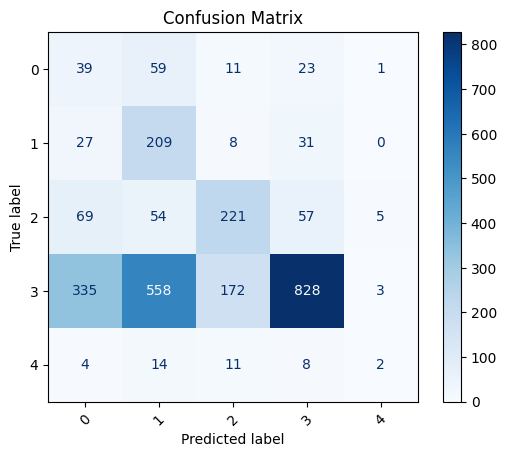

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get predictions and true labels
y_pred = []
y_true = []

# Iterate through test data to get predictions and true labels
for images, labels in test_data:
    # Predict using the best model
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Get true class indices

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_test)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# focal loss model

TRIED TO CHANGE LOSS FUNCTION TO FOCAL LOSS

In [3]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.sum(loss, axis=1)
    return focal_loss_fixed

In [4]:
from tensorflow.keras import backend as K
import tensorflow as tf

def focal_lossW(gamma=2., alpha=None):
    """
    Focal Loss for Multi-class Classification with Per-Class Weights.

    Args:
        gamma (float): Focusing parameter to down-weight easy examples.
        alpha (list or None): Class weighting factor.
                              Pass a list of length equal to the number of classes, or None for no weighting.

    Returns:
        Focal loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        alpha_tensor = K.constant(alpha)  # Convert alpha to a tensor
        alpha_factor = y_true * alpha_tensor  # Apply per-class alpha weights

        # Compute the focal loss
        loss = -alpha_factor * K.pow(1 - y_pred, gamma) * K.log(y_pred)

        # Reduce the loss across classes (sum per sample)
        loss = K.sum(loss, axis=-1)

        # Return mean loss across the batch
        return K.mean(loss)

    return focal_loss_fixed


## calculation of the wheight to give to different classes to compute alpha vector

The dataset is imbalanced (some classes have far fewer samples than others), so I'll compute the **inverse of class frequencies** to assign higher weights to underrepresented classes.

Steps:

1. **Count the Samples per Class:**  
   For each class, count the number of samples in the training dataset.

2. **Calculate Class Weights (Inverse Frequencies):** The formula for the weight of each class \( w_c \) is:
   $$
   w_c = \frac{1}{\text{frequency of class } c}
   $$

I'll then normalize the weights so that they sum to 1.


In [ ]:
'''
labels Shape: Each labels batch is a tensor of shape (batch_size, num_classes), where each row is a one-hot-encoded vector indicating the class of a sample in the batch.
Summing Along Batch: By summing along the batch (tf.reduce_sum(labels[:, class_index])), we get the total number of samples for a specific class in the batch.
Then accumulate the count
'''

# Initialize counters for each class
n_class0 = 0
n_class1 = 0
n_class2 = 0
n_class3 = 0
n_class4 = 0

# Iterate through the training data
for _, labels in train_data:
    n_class0 += tf.reduce_sum(labels[:, 0]).numpy()
    n_class1 += tf.reduce_sum(labels[:, 1]).numpy()
    n_class2 += tf.reduce_sum(labels[:, 2]).numpy()
    n_class3 += tf.reduce_sum(labels[:, 3]).numpy()
    n_class4 += tf.reduce_sum(labels[:, 4]).numpy()

# Iterate through the validation data
for _, labels in val_data:
    n_class0 += tf.reduce_sum(labels[:, 0]).numpy()
    n_class1 += tf.reduce_sum(labels[:, 1]).numpy()
    n_class2 += tf.reduce_sum(labels[:, 2]).numpy()
    n_class3 += tf.reduce_sum(labels[:, 3]).numpy()
    n_class4 += tf.reduce_sum(labels[:, 4]).numpy()

# Print the results
print("Class 0:", n_class0)
print("Class 1:", n_class1)
print("Class 2:", n_class2)
print("Class 3:", n_class3)
print("Class 4:", n_class4)


Class 0: 1000.0
Class 1: 1500.0
Class 2: 1500.0
Class 3: 2000.0
Class 4: 369.0


In [ ]:
import numpy as np

# Class sample counts
class_counts = [n_class0, n_class1, n_class2, n_class3, n_class4]  # Example: Counts of samples in classes 0 to 4

# Compute the inverse frequency weights
alpha = 1.0 / np.array(class_counts)

# Normalize to ensure the weights sum to 1
alpha /= alpha.sum()

print("Alpha (Per-Class Weights):", alpha)


Alpha (Per-Class Weights): [0.18039599 0.12026399 0.12026399 0.090198   0.48887804]


## dynamic lr model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model(learning_rate, stride, num_layers, num_dense_layers, dense_units, glob_avg_pooling, max_pooling):
    num_layers = int(num_layers)
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(96, 96, 3)))

    # Add convolutional + pooling layers dynamically
    for i in range(num_layers):
        model.add(layers.Conv2D(16 * (2 ** i), (3, 3), strides=stride, activation='relu',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())

        if max_pooling:
            model.add(layers.MaxPooling2D((2, 2)))
        else:
            model.add(layers.AveragePooling2D(2, 2))

    # Global Average Pooling
    if glob_avg_pooling:
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())

    # Fully connected layers
    for _ in range(num_dense_layers):
        model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    #model.add(layers.Dropout(dropout_rate))  # Dropout for regularization
    model.add(layers.Dense(5, activation='softmax'))  # 5 classes

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
              loss=focal_loss(gamma=2.0, alpha=None),
              metrics=['accuracy', f1_score])
    return model

# Define the grid of hyperparameters
param_grid = {
    'stride': [(1, 1), (2, 2)],
    'num_layers': [2, 3],
    'learning_rate': [0.01],
    'num_dense_layers': [3, 4],  # Number of dense layers to explore
    'dense_units': [64, 128],   # Number of units in each dense layer  # Dropout rate for dense layers
    'epochs': [30, 50],
    'glob_avg_pooling': [True, False],
    'max_pooling': [True, False]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
#model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model_dense_layers.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1)



In [ ]:
# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_accuracy = 0
best_params = {}

# List to log results
results_log = []

# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model(params['stride'], params['num_layers'], params['learning_rate'],
                        params['num_dense_layers'], params['dense_units'], params['glob_avg_pooling'], params['max_pooling'])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],
        callbacks=[early_stopping, lr_scheduler],
        ##class_weight=class_weights_dict,
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history.history['val_accuracy'])
    val_f1_score = max(history.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params
        best_accuracy = val_accuracy

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")

# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)

# Save results to a CSV file for future analysis
results_df.to_csv("grid_search_dense_results.csv", index=False)

Testing with params: {'dense_units': 64, 'epochs': 30, 'glob_avg_pooling': True, 'learning_rate': 0.01, 'max_pooling': True, 'num_dense_layers': 3, 'num_layers': 2, 'stride': (1, 1)}
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2756 - f1_score: 0.0844 - loss: 0.4448 - val_accuracy: 0.3205 - val_f1_score: 0.0958 - val_loss: 0.2349 - learning_rate: 0.0100
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3136 - f1_score: 0.0945 - loss: 0.2280 - val_accuracy: 0.3205 - val_f1_score: 0.0961 - val_loss: 0.2360 - learning_rate: 0.0100
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3034 - f1_score: 0.0919 - loss: 0.2285 - val_accuracy: 0.3205 - val_f1_score: 0.0949 - val_loss: 0.2354 - learning_rate: 0.0100
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3152 - f1_score: 0.0948 - loss: 0.2283 - val_accuracy: 0.3205 - val_f1_score: 0.0960 - val_loss: 0.2346 - learning_rate: 0.0100
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
# Save the best model explicitly after the grid search finishes
best_model_path = "best_gridsearch_another_model.keras"

if best_model is not None:
    best_model.save(best_model_path)
    print(f"Best model saved to: {best_model_path}")
else:
    print("No model to save. Grid search did not yield a best model.")

Best model saved to: best_gridsearch_another_model.keras


In [ ]:
# evaluate the best model on the test data
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6763 - f1_score: 0.1609 - loss: 0.1853
Test Loss: 0.18225984275341034
Test Accuracy: 0.6897
Test F1 Score: 0.1628


## fixed lr model

10 HOURS RUN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model(learning_rate, stride, num_layers, num_dense_layers, dense_units, glob_avg_pooling, max_pooling):
    num_layers = int(num_layers)
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(96, 96, 3)))

    # Add convolutional + pooling layers dynamically
    for i in range(num_layers):
        model.add(layers.Conv2D(16 * (2 ** i), (3, 3), strides=stride, activation='relu',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())

        if max_pooling:
            model.add(layers.MaxPooling2D((2, 2)))
        else:
            model.add(layers.AveragePooling2D(2, 2))

    # Global Average Pooling
    if glob_avg_pooling:
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())

    # Fully connected layers
    for _ in range(num_dense_layers):
        model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    #model.add(layers.Dropout(dropout_rate))  # Dropout for regularization
    model.add(layers.Dense(5, activation='softmax'))  # 5 classes

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
              loss=focal_loss(2.0, alpha=None),
              metrics=['accuracy', f1_score])
    return model

# Define the grid of hyperparameters
param_grid = {
    'stride': [(1, 1), (2, 2)],
    'num_layers': [2, 3],
    'learning_rate': [0.0001, 0.005, 0.01],
    'num_dense_layers': [3, 4],  # Number of dense layers to explore
    'dense_units': [64, 128],   # Number of units in each dense layer  # Dropout rate for dense layers
    'epochs': [30, 50],
    'glob_avg_pooling': [True, False],
    'max_pooling': [True, False]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)


## normal focal loss

In [ ]:
# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_accuracy = 0
best_params = {}

# List to log results
results_log = []

# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model(params['stride'], params['num_layers'], params['learning_rate'],
                        params['num_dense_layers'], params['dense_units'], params['glob_avg_pooling'], params['max_pooling'])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],
        callbacks=[early_stopping],
        ##class_weight=class_weights_dict,
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history.history['val_accuracy'])
    val_f1_score = max(history.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params
        best_accuracy = val_accuracy

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")

# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)

# Save results to a CSV file for future analysis
results_df.to_csv("grid_search_dense_results.csv", index=False)

Testing with params: {'dense_units': 64, 'epochs': 30, 'glob_avg_pooling': True, 'learning_rate': 0.0005, 'max_pooling': True, 'num_dense_layers': 3, 'num_layers': 2, 'stride': (1, 1)}
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2864 - f1_score: 0.0869 - loss: 1.2866 - val_accuracy: 0.3205 - val_f1_score: 0.0960 - val_loss: 0.6585
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3144 - f1_score: 0.0946 - loss: 0.5525 - val_accuracy: 0.3205 - val_f1_score: 0.0961 - val_loss: 0.3525
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3131 - f1_score: 0.0942 - loss: 0.3168 - val_accuracy: 0.3205 - val_f1_score: 0.0961 - val_loss: 0.2626
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3163 - f1_score: 0.0951 - loss: 0.2491 - val_accuracy: 0.3205 - val_f1_score: 0.0961 - val_loss: 0.2401
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3187 - f1_score: 0.0955 - loss: 0.2325 - val_accuracy: 0.3205 - 

In [ ]:
# Save the best model explicitly after the grid search finishes
best_model_path = "best_gridsearch_another_model_fixed_lr.keras"

if best_model is not None:
    best_model.save(best_model_path)
    print(f"Best model saved to: {best_model_path}")
else:
    print("No model to save. Grid search did not yield a best model.")

Best model saved to: best_gridsearch_another_model_fixed_lr.keras


In [ ]:
# evaluate the best model on the test data
test_loss, test_accuracy, test_f1 = model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6840 - f1_score: 0.1621 - loss: 0.1838
Test Loss: 0.18239662051200867
Test Accuracy: 0.6897
Test F1 Score: 0.1627


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

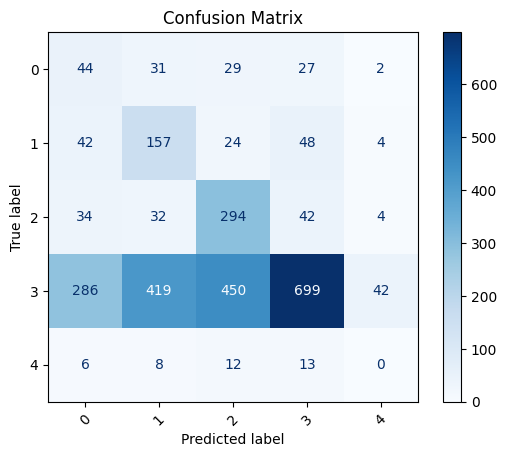

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get predictions and true labels
y_pred = []
y_true = []

# Iterate through test data to get predictions and true labels
for images, labels in test_data:
    # Predict using the best model
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Get true class indices

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_test)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


### weighted focal loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pandas as pd

# Define the model builder function
def build_model(learning_rate, stride, num_layers, num_dense_layers, dense_units, glob_avg_pooling, max_pooling):
    num_layers = int(num_layers)
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(96, 96, 3)))

    # Add convolutional + pooling layers dynamically
    for i in range(num_layers):
        model.add(layers.Conv2D(16 * (2 ** i), (3, 3), strides=stride, activation='relu',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())

        if max_pooling:
            model.add(layers.MaxPooling2D((2, 2)))
        else:
            model.add(layers.AveragePooling2D(2, 2))

    # Global Average Pooling
    if glob_avg_pooling:
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())

    # Fully connected layers
    for _ in range(num_dense_layers):
        model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))


    # Output layer
    #model.add(layers.Dropout(dropout_rate))  # Dropout for regularization
    model.add(layers.Dense(5, activation='softmax'))  # 5 classes

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
              loss=focal_lossW(2.0, alpha=alpha),
              metrics=['accuracy', f1_score])
    return model

# Define the grid of hyperparameters
param_grid = {
    'stride': [(1, 1), (2, 2)],
    'num_layers': [2, 3],
    'learning_rate': [0.0001, 0.005, 0.01],
    'num_dense_layers': [3, 4],  # Number of dense layers to explore
    'dense_units': [64, 128],   # Number of units in each dense layer  # Dropout rate for dense layers
    'epochs': [30, 50],
    'glob_avg_pooling': [True, False],
    'max_pooling': [True, False]
}

# Create the parameter combinations
grid = list(ParameterGrid(param_grid))

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)


In [ ]:
# Initialize variables to track the best model
best_model = None
best_val_f1_score = 0  # Initialize to track the best F1 score
best_accuracy = 0
best_params = {}

# List to log results
results_log = []

# Iterate through the parameter grid
for params in grid:
    print(f"Testing with params: {params}")

    # Build and train the model
    model = build_model(params['stride'], params['num_layers'], params['learning_rate'],
                        params['num_dense_layers'], params['dense_units'], params['glob_avg_pooling'], params['max_pooling'])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=params['epochs'],
        callbacks=[early_stopping],
        ##class_weight=class_weights_dict,
        verbose=1
    )

    # Get the maximum validation accuracy and F1 score
    val_accuracy = max(history.history['val_accuracy'])
    val_f1_score = max(history.history['val_f1_score'])

    # Log the results
    results_log.append({
        'params': params,
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1_score,
        'val_loss': min(history.history['val_loss']),
    })

    # Compare based on F1 score instead of accuracy
    if val_f1_score > best_val_f1_score:
        best_val_f1_score = val_f1_score
        best_model = model
        best_params = params
        best_accuracy = val_accuracy

# After the grid search is complete, print the best parameters
print(f"Best Parameters (based on F1 Score): {best_params}")
print(f"Best Validation F1 Score: {best_val_f1_score}")

# Convert the results log into a DataFrame for analysis
results_df = pd.DataFrame(results_log)

# Save results to a CSV file for future analysis
results_df.to_csv("grid_search_dense_results.csv", index=False)

Testing with params: {'dense_units': 64, 'epochs': 30, 'glob_avg_pooling': True, 'learning_rate': 0.0001, 'max_pooling': True, 'num_dense_layers': 3, 'num_layers': 2, 'stride': (1, 1)}
Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0532 - f1_score: 0.0197 - loss: 1.4006 - val_accuracy: 0.1485 - val_f1_score: 0.0971 - val_loss: 1.2132
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1972 - f1_score: 0.0699 - loss: 1.1505 - val_accuracy: 0.2270 - val_f1_score: 0.0730 - val_loss: 0.9998
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2408 - f1_score: 0.0765 - loss: 0.9473 - val_accuracy: 0.2270 - val_f1_score: 0.0728 - val_loss: 0.8259
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2333 - f1_score: 0.0750 - loss: 0.7820 - val_accuracy: 0.2145 - val_f1_score: 0.1000 - val_loss: 0.6843
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2376 - f1_score: 0.0867 - loss: 0.6470 - val_accuracy: 0.2239 - val

In [ ]:
# Save the best model explicitly after the grid search finishes
best_model_path = "best_gridsearch_another_model_fixed_lr_new_focal_loss.keras"

if best_model is not None:
    best_model.save(best_model_path)
    print(f"Best model saved to: {best_model_path}")
else:
    print("No model to save. Grid search did not yield a best model.")

Best model saved to: best_gridsearch_another_model_fixed_lr_new_focal_loss.keras


In [ ]:
# evaluate the best model on the test data
test_loss, test_accuracy, test_f1 = best_model.evaluate(test_data, verbose=1)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6345 - f1_score: 0.3361 - loss: 0.1225
Test Loss: 0.12287212908267975
Test Accuracy: 0.6282
Test F1 Score: 0.3275


### confusion matrix

In [8]:
from tensorflow.keras import models
best_model = models.load_model("/content/drive/MyDrive/best_gridsearch_another_model_fixed_lr_new_focal_loss.keras", custom_objects={'focal_loss_fixed': focal_lossW, 'f1_score': f1_score})

In [9]:
best_model.summary()

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)                 │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_268 (Dense)                    │ (None, 64)                  │       1,769,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_269 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_270 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_271 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,334,545 (20.35 MB)

 Trainable params: 1,778,181 (6.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,556,364 (13.57 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

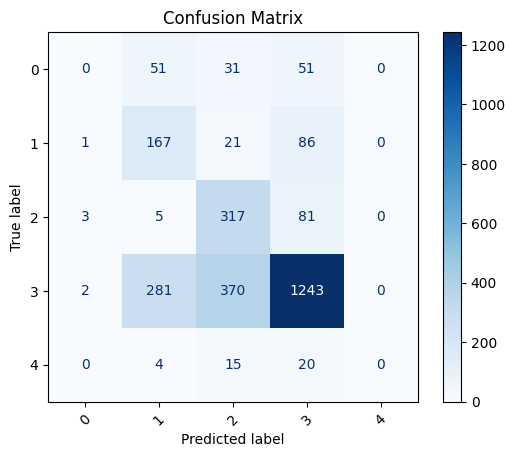

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get predictions and true labels
y_pred = []
y_true = []

# Iterate through test data to get predictions and true labels
for images, labels in test_data:
    # Predict using the best model
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Get true class indices

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_test)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
